# Aprendizaje por refuerzo profundo - Libreta 10
*por Roberto-Esteban López*

Objetivos:
- Programación de un agente para A2C

In [ ]:
# Importaciones
# Algebra
import numpy as np
import math
import numba
from numba.typed import List
# Tensores
import torch
from torch import nn
import torch.nn.functional as F
from torch import distributions
# GYM
from gym import make
import time
# Imagenes y graficas
import cv2
import matplotlib.pyplot as plt 

In [ ]:
# Functions
ceil = math.ceil
Tsum = torch.sum
Tsqrt = torch.sqrt
Tlog = torch.log
cat = torch.cat
mul, div = torch.mul, torch.div
mean, std = torch.mean, torch.std
exp = torch.exp

# DEFAULTS 

F_DTYPE_DEFT = torch.float32
DEVICE_DEFT = torch.device("cpu")
OPT_DEF = "adam"

def getDevice(cudaTry:bool = True):
    if torch.cuda.is_available() and cudaTry:
        return torch.device("cuda")
    return DEVICE_DEFT

# Custom functions
def toT(arr:np.ndarray, device = DEVICE_DEFT, dtype = F_DTYPE_DEFT, grad: bool = False):
        arr = np.squeeze(arr) # Fix due to a problem in Pendulum Observation, seems arbritary when it fails or not.
        return torch.as_tensor(arr, dtype = dtype, device = device).unsqueeze(0).requires_grad_(grad)

def copyDictState(net, grad:bool = True):
    newSD = dict()
    sd = net.state_dict()
    for i in sd.keys():
        t = sd[i]
        newSD[i] = t.new_empty(t.shape, requires_grad=grad).copy_(t)
    return newSD

def cloneNet(net):
    new = net._new_()
    new.load_state_dict(copyStateDict(net), strict = True)
    return new.to(net.device)

def updateNet(net, targetLoad):
    #net.opParams = copyStateDict(net)
    if isinstance(targetLoad, dict):
        net.load_state_dict(targetLoad)
    elif isinstance(targetLoad, list):
        for p, pt in zip(targetLoad, net.parameters()):
            pt.requires_grad_(False) # This is a must to change the values properly
            pt.copy_(p).detach_()
            pt.requires_grad_(True)

def getDictState(net, cpu):
    stateDict = net.state_dict()
    if cpu:
        for key in stateDict.keys():
            stateDict[key] = stateDict[key].to(DEVICE_DEFT)
    return stateDict

def getListState(net, cpu):
    params = []
    for p in net.parameters():
        params += [p if not cpu else p.clone().to(DEVICE_DEFT)]
    return params

def graphResults(means, var, testFreq, mod:str, dpi=200):
    mean = np.array(means)
    stds = np.sqrt(np.array(var))
    fig = plt.figure(dpi=dpi)
    plt.title("{}: Accumulated Reward per Episode".format(mod))
    plt.xlabel("Episode")
    plt.ylabel("Accumulate Reward")
    x = np.arange(0,len(means)*testFreq, testFreq)
    plt.plot(x, means, label = "Accumulate Reward", lw = 2)
    plt.fill_between(x, means - stds, means + stds, alpha = 0.1)


## A2C
A3C, y consecuentemente las ideas para A2C, fue publicado antes que el método anterior: PPO. Ambos algoritmos comparten mucho en su estructura, en particular con A2C, dado que ambos utilizan actualizaciones controladas (o síncronas) de los parámetros.

Así que las novedades que se presentaron en PPO; a excepción de GAE, fueron propuestas y utilizadas antes en estos algoritmos. Estás novedades serían:
- Habilitar el uso de arquitecturas parametricas que comparten parametros entre el actor y el crítico.
- Reemplazar el mecánismo de *experience replay* con el uso de $N$ agentes (o actores, pero igual estoy evitando llamarlos igual para poder distinguirlos rápido, un agente contiene un actor), para formar un conjunto de experiencias nuevas con periodos de $T$ pasos, resultando en $NT$ datos disponibles para actualizar los parámetros.
- Esto mismo permite las funciones de actualización *On-Policy*, con lo que se busca un aprendizaje rápido
- A2C que se implementará en esta libreta tiene la gran deferencia contra A3C de no perimitir una actualización asíncrona de los parámetros. Por lo cual hay cierta perdida de rendimiento en estas pausas por los bloqueos, pero al vez asegura un comportamiento esperado del aprendizaje


### Arquitectura Actor-critico

A continuación se definine de nuevo el objecto abstracto Actor-critico con pytorch, para representar estas arquitecturas compartidas.
Como usual, es buena costumbre intentar declarar primero objetos abstractos que solo indiquen que esperamos que tengan todos aquellos basados en este, y que esperar al programar funciones cuando operamos dicho objecto, y todo esto sin estár trabajando en particular con uno solo.

In [ ]:
class ActorCritic(nn.Module):
    """
    Class designs to host both actor and critic for those architectures when a start 
    part is shared like a feature extraction from a CNN as for DQN-Atari.
    """
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.name = "Actor_critic"
        self.discrete = True
        self.__dvc__ = None
    
    def sharedForward(self, x):
        """
        From the observation, extracts the features. Recomended to return the 
        flatten tensor in batch form
        """
        raise NotImplementedError

    def valueForward(self, x):
        """
        From the feature extraction. Calculates the value from said observation
        """
        raise NotImplementedError

    def actorForward(self, x):
        """
        From the feature extraction. Calculates the raw output to represent the parameters
        for the actions distribution.
        """
        raise NotImplementedError

    def getDist(self, x):
        """
        From the actorForward, returns the corresponding pytorch distributions objecto to 
        sample the action from and to return .log_prob()
        """
        raise NotImplementedError

    def forward(self, x):
        features = self.sharedForward(x)
        values = self.valueForward(features)
        raw_actor = self.actorForward(features.clone())

        return values, raw_actor

    def getAction(self, x):
        """
        From a tensor observation returns the sampled actions and 
        their corresponding log_probs from the distribution.

        returns
        -------
        action, log_prob, entropy
        """
        with torch.no_grad():
            distParams = self.actorForward(self.sharedForward(x))
        return self.sampleAction(distParams)
    
    def sampleAction(self, params):
        """
        Creates, samples and returns the action and log_prob for it

        parameters
        ----------
        params:
            Raw output logits from the network

        returns
        action, log_prob, entropy
        """
        dist = self.getDist(params)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        
        if self.discrete:
            action = action.item()
        else:
            action.to(DEVICE_DEFT).squeeze(0).numpy()

        return action, log_prob, entropy

    def getValue(self, x):
        """
        Form a tensor observation returns the value approximation 
        for it with no_grad operation.
        """
        with torch.no_grad():
            value = self.valueForward(self.sharedForward(x))
        return value.item()

    def _new_(self):
        """
        This method must return the same architecture when called from a 
        already given network.
        """
        raise NotImplementedError

    @property
    def device(self):
        if self.__dvc__ is None:
            self.__dvc__ =  next(self.parameters()).device
        return self.__dvc__

#### Actor crítico - Arquitectura aproximador

El objeto a continuación, es una política basada en la clase anterior. Dónde  se comparte parte de la arquitectura para realizar las estimaciones de las acciones del *Actor* y del *Crítico*.

In [ ]:
class ACNet_discrete(ActorCritic):
    def __init__(self, kwargs):
        super(ACNet_discrete, self).__init__()
        self.name = "ActorCritic"
        # Defaults
        inpts = kwargs["nInput"]
        actions, h0 = kwargs["nActions"], kwargs.get("hidden0", 52)
        self.kwargs = kwargs
        self.rectifier = F.relu
        # Actions
        self.fc1 = nn.Linear(inpts, h0)
        self.fc2 = nn.Linear(h0, actions)
        # Value function
        self.fc3 = nn.Linear(h0, 1)

    def sharedForward(self, x):
        x = self.rectifier(self.fc1(x))
        return x

    def valueForward(self, x):
        return self.fc3(x)

    def actorForward(self, x):
        return self.fc2(x)

    def getDist(self, x):
        return distributions.Categorical(logits = x)
        
    def _new_(self):
        new = ACNet_discrete(self.kwargs)
        return new

In [ ]:
def envMaker(name):
    
    def ENV(seed = None):
        if seed is not None and seed < 0:
            seed = None
        env = make(name)
        seeds = env.seed(seed)
        return env, seeds

    return ENV

### Agente

Hay distintas maneras de manjear y administrar agentes, estos bien podrían ser considerados solo algunas variaciones de parametros; como las semillas de aleatroriedad, de una estructura compartida(un objeto o función). En python, es sencillo ver este tipo de tareas como un objeto. Como se implemento en DQN de nuevo tendremos una clase *Actor*, aunque ahorita se cambia de nombre a *Agent* para no mezclar con el concepto de *actor* en actor-critic.

In [ ]:

class Agent:
    def __init__(self, envMaker,
                    actorCritic,
                    config,
                    seedTrain: int = -1,
                    seedTest: int = -1):

        self.env, self.envSeed = envMaker(seedTrain)
        self.envTest, self.envTestSeed = envMaker(seedTest)
        self.config = config
        self.AC = actorCritic(config)
        self._lastkey = 0

        self.nStep = config.get("n-step", 1)
        self.done = True
        self.obs = None
        self.steps = 0
        self.lastUpdate = 0
        self.episodes = 0

        self.frame = None

    def updateAC(self,targetParams, key):
        if key <= self._lastkey:
            return None
        updateNet(self.AC, targetParams)
        self._lastkey = key


    def processObs(self, obs):
        return toT(obs)

    def developEpisode(self):
        env = self.env
        obs = self.obs

        if self.done:
            obs = env.reset()
            self.frame = None
            obs = self.processObs(obs)
            self.done = False

        log_actions, entropies, values, rewards = [], [], [], List()

        while True:
            # Get output from actor-critic
            valueOut, policyOut = self.AC.forward(obs)
            # Sample action from the actions distribution
            action, log_action, entropy = self.AC.sampleAction(policyOut)
            # Observe next state and reward
            nextObs, reward, done, _ = env.step(action)
            # Register experience
            self.steps += 1
            values += [valueOut]
            log_actions += [log_action]
            entropies += [entropy]
            rewards.append(float(reward))

            obs = self.processObs(nextObs)

            if (self.steps - self.lastUpdate) == self.nStep or done:
                # set variables
                self.done = done
                self.episodes += 1 if done else 0
                self.frame = None if done else self.frame
                self.obs = obs
                self.lastUpdate = self.steps
                # prepare bootstrapping
                rewards.append(0.0 if done else self.AC.getValue(obs))
                break
        # Calculate grads
        self.calculateGradients(log_actions, values, rewards, entropies)       
        return self.gradients, 1 if self.done else 0
    
    def calculateGradients(self, log_actions, baselines, rewards, entropies):
        # Set tensors
        n = len(log_actions)
        log_actions = torch.cat(log_actions)
        baselines = torch.cat(baselines).squeeze(1)
        entropies = torch.cat(entropies)
        returns = self.calculateReturns(rewards, self.config.get("gamma", 1.0))
        returns = torch.as_tensor(returns, dtype=F_DTYPE_DEFT)
        # Get parameters
        beta = self.config.get("entropyLoss", 0.0)
        cPolicyLoss = config.get("cPolicyLoss", 1.0)
        cValueLoss = config.get("cValueLoss", 1.0)
        #gradClip = config.get("gradClip", np.inf)
        # Reset grads
        self.AC.zero_grad()
        # Calculate losses
        policyTarget = returns - baselines.detach()
        lossPolicy = - 1.0 * torch.mean(cPolicyLoss * log_actions * policyTarget.unsqueeze(1) + beta * entropies)
        lossValue = F.mse_loss(baselines, returns)
        loss = lossPolicy + cValueLoss * lossValue
        loss.backward()
        # Clip the gradients
        #torch.nn.utils.clip_grad_norm_(self.AC.parameters(), gradClip)

    @property
    def gradients(self):
        grads = []
        for p in self.AC.parameters():
            grads += [p.grad.clone().detach_()]
        return grads

    @staticmethod
    @numba.njit
    def calculateReturns(rewards:List, gamma:float):
        n = len(rewards) - 1
        returns = np.zeros(n, dtype = np.float32)
        # Bootstrapping
        returns[n - 1] = rewards[n - 1] + gamma * rewards[n]
        for i in range(n - 2, -1, -1):
            returns[i] = rewards[i] + gamma * returns[i + 1]
        return returns

    def test(self, prnt: bool = True):
        env = self.envTest
        # Reset the atari observation if needed
        lastFrame = self.frame
        # Setting variables
        nTest, stepsTest = self.config["nTest"], self.config["stepsTest"]
        meanRunReward, meanC, stepsMean, var = 0, 1 / nTest, 0, []
        # Running tests
        for i in range(nTest):
            # Start Test
            done, accReward, steps = False, 0.0, 0

            obs = env.reset()
            self.frame = None
            obs = self.processObs(obs)

            while not done:
                action, _, _ = self.AC.getAction(obs)
                nextObs, reward, done, _ = env.step(action)
                accReward += reward
                steps += 1
                if stepsTest > 0 and steps > stepsTest:
                    done = True
                else:
                    obs = self.processObs(nextObs)
            # Save results from test
            #if isinstance(accReward, (np.ndarray)):
             #   accReward = accReward[0]
            meanRunReward += accReward * meanC
            stepsMean += steps * meanC
            var += [accReward]
        # Calculate variance
        tVar = 0
        for v in var:
            tVar += meanC * (v - meanRunReward)**2
        if prnt:
            s = "Means: accumulate_reward {:.3f}, variance {:.3f}, steps {:.3f}".format(meanRunReward, tVar, stepsMean)
            print(s)
        # Reseting state
        self.frame = lastFrame
        return meanRunReward, tVar, stepsMean

### Aprendíz (Learner)

Y a continuación el objecto que centraliza todos los gradientes que llegan de los otros *agentes*. Este objeto contiene en sí el optimizador SGD o alguna variación de esté. En particula ahorita por default se hace uso de ADAM.

In [ ]:
class Learner:
    def __init__(self, actorCritic,
                        config):

        self.AC = actorCritic(config)
        self.config = config
        self.updates = 0

        optimizer = config.get("optimizer", "Adam")
        params = self.AC.parameters()
        if optimizer == "Adam":
            self.optimizer = torch.optim.Adam(params, lr=config["learningRate"], **config["optimizerArgs"])
        elif optimizer == "RMSprop":
            self.optimizer = torch.optim.RMSprop(params, lr=config["learningRate"], **config["optimizerArgs"])
        else:
            raise KeyError("Optimizer key not recognized")
        
        self.zeroGrad()

    def zeroGrad(self):
        """
        Sets the gradient from NoneType or else to zero.
        returns None
        """
        for p in self.AC.parameters():
            p.grad = p.new_zeros(p.shape)

    def addGrads(self, *grads):
        """
        Gets all the gradients from the other nets and accumulates in the main network.
        """
        for grad in grads:
            for p, g in zip(self.AC.parameters(), grad):
                p.grad.add_(g)
    
    def optimize(self):
        """
        Applies the optimizer step and set to zero the gradient.
        """
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.updates += 1
        return self.parameters, self.updates

    @property
    def parameters(self):
        """
        Returns the cpu list of parameters
        """
        return getListState(self.AC, True)

    def model(self):
        return self.AC

## Configurando el experimento

Con todos los elementos listos, solo queda configurar el experimento y la función de entrenamiento.


In [ ]:
envmake = envMaker("CartPole-v0")

config = {
    "n-step": 20,
    "gamma" : 0.99,
    "learningRate" : 5e-4,
    "optimizer" : "Adam",
    "optimizerArgs" : {},
    "nActions" : 2,
    "nInput": 4,
    "hidden0": 52,
    "cPolicyLoss": 1.0,
    "cValueLoss": 0.5,
    "entropyLoss": 0.00,
    "nTest" : 20,
    "stepsTest" : -1,
}

N_AGENTS = 8
TRAIN_EPOCHS = 10**4
TEST_FREQ = 10**3

In [ ]:
# Setting agents
agents = [Agent(envmake, ACNet_discrete, config.copy(), i, (i + 1)* 10) for i in range(N_AGENTS)]

In [ ]:
# Setting learner
learner = Learner(ACNet_discrete, config)

In [ ]:
# Training loop
def train(actors, learner, episodes:int = 50, freqTest:int = 10):
    testAR, testRV, testS = [], [], []
    totEpisodes, lastTot, lastTest = 0, 0, 0
    startTime, totTime = time.time(), 0

    while totEpisodes < episodes:
        # Testing perfomance
        if (totEpisodes - lastTest) >= freqTest:
            print("Starting testing", end="")
            mean, var, steps = actors[0].test(False)
            testAR += [mean]
            testRV += [var]
            testS += [steps]
            lastTest = totEpisodes
            print(" -- Test Completed, mean accumulated Reward {:.2f}".format(mean))
        # Obtain grads from agents
        for actor in actors:
            grad, episode = actor.developEpisode()
            totEpisodes += episode
            learner.addGrads(grad)
        # Calculate and Sync latest parameters
        newParams, key = learner.optimize()
        # Sync params
        for actor in actors:
            actor.updateAC(newParams, key)
        # Tracking episodes
        if totEpisodes != lastTot:
            elapsedTime = time.time() - startTime
            startTime = time.time()
            totTime += elapsedTime
            print("Completed episodes {} of {} in {:d}m:{:.1f}s".format(totEpisodes, episodes, int(elapsedTime) // 60, elapsedTime % 60 ))
            lastTot = totEpisodes

    print("Training done in {:d}m:{:.1f}s".format(int(totTime // 60),totTime % 60))
    return testAR, testRV, testS

In [ ]:
testAR, testRV, testS = train(agents, learner, TRAIN_EPOCHS, TEST_FREQ)

Se han truncado las últimas 5000 líneas del flujo de salida.
Completed episodes 2103 of 10000 in 0m:0.1s
Completed episodes 2106 of 10000 in 0m:0.1s
Completed episodes 2110 of 10000 in 0m:0.1s
Completed episodes 2112 of 10000 in 0m:0.1s
Completed episodes 2117 of 10000 in 0m:0.1s
Completed episodes 2118 of 10000 in 0m:0.1s
Completed episodes 2121 of 10000 in 0m:0.1s
Completed episodes 2123 of 10000 in 0m:0.1s
Completed episodes 2125 of 10000 in 0m:0.1s
Completed episodes 2127 of 10000 in 0m:0.1s
Completed episodes 2131 of 10000 in 0m:0.1s
Completed episodes 2135 of 10000 in 0m:0.1s
Completed episodes 2138 of 10000 in 0m:0.1s
Completed episodes 2141 of 10000 in 0m:0.1s
Completed episodes 2144 of 10000 in 0m:0.1s
Completed episodes 2148 of 10000 in 0m:0.1s
Completed episodes 2152 of 10000 in 0m:0.1s
Completed episodes 2155 of 10000 in 0m:0.1s
Completed episodes 2159 of 10000 in 0m:0.1s
Completed episodes 2161 of 10000 in 0m:0.1s
Completed episodes 2164 of 10000 in 0m:0.1s
Completed episo

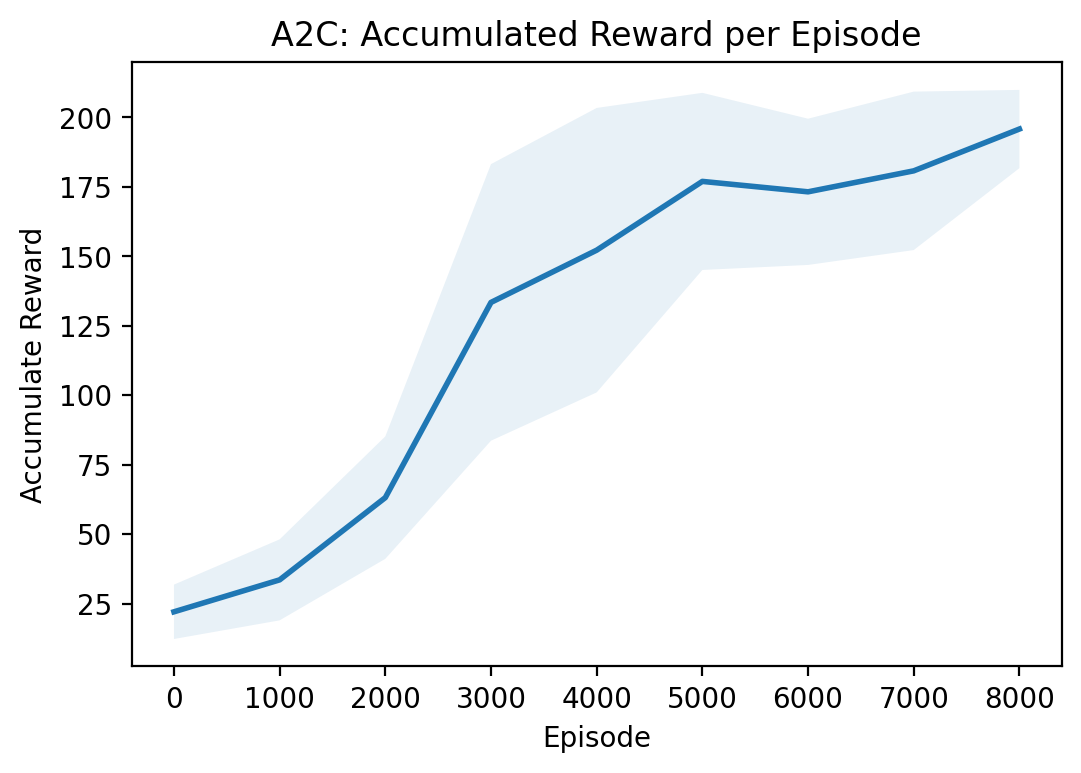

In [ ]:
graphResults(testAR, testRV, TEST_FREQ, "A2C")